# SURVIVAL ANALYSIS

#### Prepared by: 
Reza Mousavi, Data Scientist, DSCoE

## Introduction

Survival analysis is generally defined as a set of methods for analyzing data where the outcome variable is the time until the occurrence of an event of interest. The event can be death, occurrence of a disease, marriage, divorce, etc. The time to event or survival time can be measured in days, weeks, years, etc. For example, if the event of interest is heart attack, then the survival time can be the time in years until a person develops a heart attack. As you can imagine, survival models can be used in a variety of contexts. One of which would be to model the amount of time that is needed for a given customer to lapse. Another example would be modeling the amount of time that is needed for a claim to be reopened. 

The target variable in survival analysis includes two parts: The first part of the target variable is the amount of time that is spent until the event takes place. The other part of the target variable is the event status, which records if the event of interest occurred or not. One can then estimate two functions that are dependent on time, the survival and hazard functions. 

The survival and hazard functions are key concepts in survival analysis for describing the distribution of event times. The survival function gives, for every time, the probability of surviving (or not experiencing the event) up to that time. The hazard function gives the potential that the event will occur, per time unit, given that an individual has survived up to the specified time. 

### Why we shouldn't use OLS?

* OLS assumes Y is Normal but duration dependent variables are always positive (number of years, number of days. etc.)

* Survival models can handle censoring: For instance if the event happens after the data collection period. 

* Survival models can handle time-varying covariates

## Hands-on Example

### UMASS Aids Research Unit IMPACT Study

The code takes the data as input and creates a survival model that estimates the probability of reusing drugs after a treatment program.

##### Description of the study:

UIS was a 5-year (1989-1994) collaborative research project (Benjamin F. Lewis, P.I., National Institute on Drug Abuse Grant #R18-DA06151) comprised of two concurrent randomized trials of residential treatment for drug abuse. The purpose of the study was to compare treatment programs of different planned durations designed to reduce drug abuse and to prevent high-risk HIV behavior. The UIS sought to determine whether alternative residential treatment approaches are variable in effectiveness and whether efficacy depends on planned program duration. We only use a small subset of variables from the original study.
* REFERENCE: Hosmer, D.W. and Lemeshow, S. and May, S. (2008)  Applied Survival Analysis: Regression Modeling of Time to Event Data:  Second Edition, John Wiley and Sons Inc., New York, NY

##### Import libraries:

"survival" library contains the core survival analysis routines, including definition of Surv objects, Kaplan-Meier and Aalen-Johansen (multi-state) curves, Cox models, and parametric accelerated failure time models. For more information about this library, refer to https://cran.r-project.org/web/packages/survival/survival.pdf.

In [43]:
library(survival)
library(ggplot2)
library(scales)
library(Hmisc)
library(ROCR)
library(randomForest)

##### Read and process the input data:

In [44]:
survival_data <- read.csv("uissurv.csv", header=TRUE,
                         colClasses=c(rep('numeric', 6), rep('factor', 3), rep('numeric', 2), 'factor'),
                         )
head(survival_data)

,id,age,beck,hercoc,ivhx,ndrugtx,race,treat,site,los,time,censor
1,1,39,9,4,3,1,0,1,0,123,188,1
2,2,33,34,4,2,8,0,1,0,25,26,1
3,3,33,10,2,3,3,0,1,0,7,207,1
4,4,32,20,4,3,1,0,0,0,66,144,1
5,5,24,5,2,1,5,1,1,0,173,551,0
6,6,30,32.55,3,3,1,0,1,0,16,32,1


##### Variables:
* AGE Age in years
* BECK Beck Depression Score
* HERCOC Heroin or Cocaine Use prior to entry 
* IVHX IV Drug use at Admission
* NDRUGTX Number previous drug treatments
* RACE Subject’s Race 
* TREAT Treatment Assignment (0=short, 1=long) 
* SITE Treatment Program (0=A,1=B)
* LOS Length of Treatment (days)
* TIME Time to Return to Drug Use (days)
* CENSOR Indicator of Drug Use Relapse (1=yes,0=censored)

In [45]:
str(survival_data)

'data.frame':	628 obs. of  12 variables:
 $ id     : num  1 2 3 4 5 6 7 8 9 10 ...
 $ age    : num  39 33 33 32 24 30 39 27 40 36 ...
 $ beck   : num  9 34 10 20 5 ...
 $ hercoc : num  4 4 2 4 2 3 4 4 2 2 ...
 $ ivhx   : num  3 2 3 3 1 3 3 3 3 3 ...
 $ ndrugtx: num  1 8 3 1 5 1 34 2 3 7 ...
 $ race   : Factor w/ 3 levels "","0","1": 2 2 2 2 3 2 2 2 2 2 ...
 $ treat  : Factor w/ 2 levels "0","1": 2 2 2 1 2 2 2 2 2 2 ...
 $ site   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ los    : num  123 25 7 66 173 16 179 21 176 124 ...
 $ time   : num  188 26 207 144 551 32 459 22 210 184 ...
 $ censor : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 2 2 2 2 ...


In [46]:
describe(survival_data) 

survival_data 

 12  Variables      628  Observations
--------------------------------------------------------------------------------
id 
      n missing  unique    Info    Mean     .05     .10     .25     .50     .75 
    628       0     628       1   314.5   32.35   63.70  157.75  314.50  471.25 
    .90     .95 
 565.30  596.65 

lowest :   1   2   3   4   5, highest: 624 625 626 627 628 
--------------------------------------------------------------------------------
age 
      n missing  unique    Info    Mean     .05     .10     .25     .50     .75 
    623       5      31       1   32.37      23      24      27      32      37 
    .90     .95 
     40      43 

lowest : 20 21 22 23 24, highest: 46 48 49 53 56 
--------------------------------------------------------------------------------
beck 
      n missing  unique    Info    Mean     .05     .10     .25     .50     .75 
    595      33      69       1    17.4       3       5      10      17      23 
    .90     .95 
     

In [47]:
colnames(survival_data)

[1] "id"      "age"     "beck"    "hercoc"  "ivhx"    "ndrugtx" "race"   
 [8] "treat"   "site"    "los"     "time"    "censor"

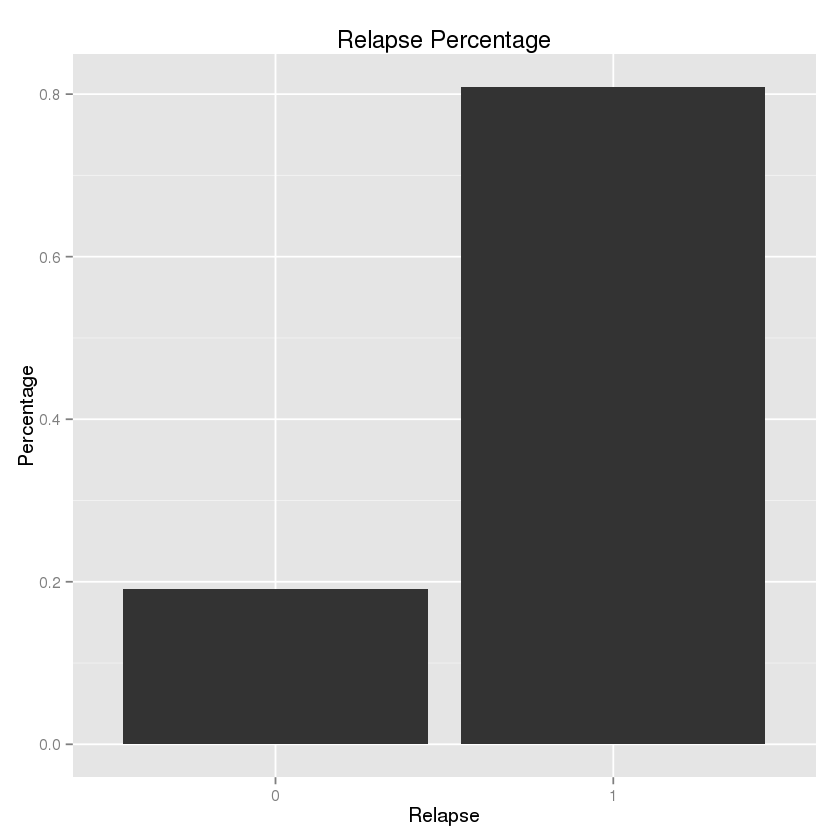

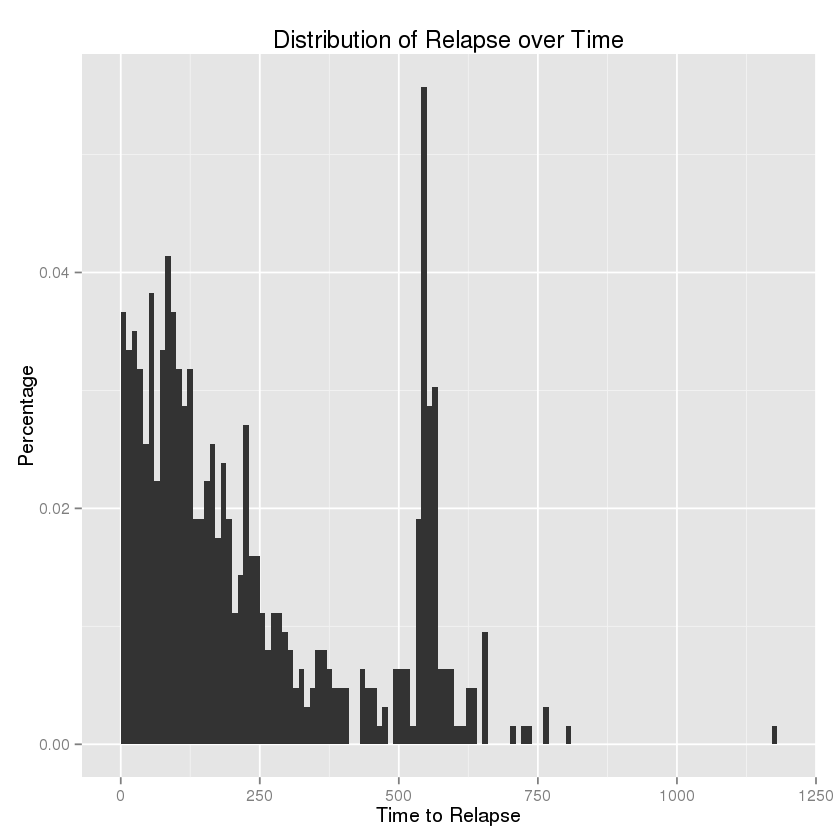

In [48]:
ggplot(survival_data, aes(censor)) + geom_bar(aes(y=..count../sum(..count..)), binwidth=.3) +
labs(x = "Relapse", y="Percentage", title = "Relapse Percentage")  
ggplot(survival_data, aes(time)) + geom_histogram(aes(y=..count../sum(..count..)), binwidth = 10) +
labs(x = "Time to Relapse", y="Percentage", title = "Distribution of Relapse over Time") 

In [49]:
summary(survival_data$time)
summary(survival_data$censor)
survival_data$censor <- as.numeric(survival_data$censor)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0    79.0   166.0   234.7   365.2  1172.0 

0   1 
120 508

##### Build the hazard model:

In [50]:
mod.hazard <- coxph(Surv(time, censor) ~ age + beck + hercoc + ivhx + ndrugtx + race + treat + site + los, 
                    data=survival_data)

summary(mod.hazard)

Call:
coxph(formula = Surv(time, censor) ~ age + beck + hercoc + ivhx + 
    ndrugtx + race + treat + site + los, data = survival_data)

  n= 579, number of events= 467 
   (49 observations deleted due to missingness)

              coef  exp(coef)   se(coef)       z Pr(>|z|)    
age     -0.0217061  0.9785278  0.0081342  -2.668  0.00762 ** 
beck     0.0043423  1.0043518  0.0049094   0.884  0.37643    
hercoc  -0.0083892  0.9916459  0.0509384  -0.165  0.86919    
ivhx     0.2192928  1.2451959  0.0684013   3.206  0.00135 ** 
ndrugtx  0.0273800  1.0277583  0.0084133   3.254  0.00114 ** 
race0    0.4237145  1.5276253  0.5900425   0.718  0.47269    
race1    0.1047012  1.1103788  0.5941373   0.176  0.86012    
treat1   0.1467002  1.1580067  0.0962941   1.523  0.12764    
site1    0.4319031  1.5401858  0.1094859   3.945 7.99e-05 ***
los     -0.0093526  0.9906910  0.0008121 -11.517  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

        exp(coef) exp(-coef) lo

* Concordance: The index of concordance is a "global" index for validating the predictive ability of a survival model. It is the fraction of pairs in your data, where the observation with the higher survival time has the higher probability of survival predicted by your model.

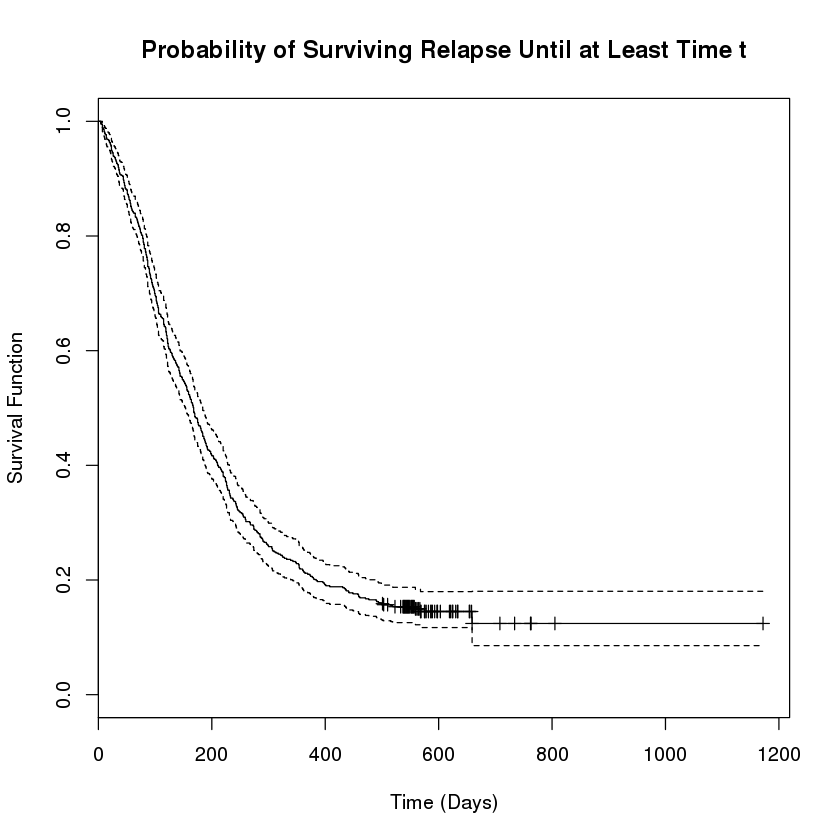

In [51]:
my.survfit.object <- survfit(mod.hazard)
plot(my.survfit.object, xlab = "Time (Days)", ylab = "Survival Function", main="Probability of Surviving Relapse Until at Least Time t")
# plot(my.survfit.object, xlab = "Time (Days)", ylab = "Cumulative Hazard Function", fun = "cumhaz")

In [52]:
### Create three new data frames.
data200 <- survival_data
data400 <- survival_data
data600 <- survival_data

Apply the created model to the original data or a new data set. The argument newdata takes the new input file. The output of this line would be the probabilities for each case. Column "Prob" is the probability that the individual would relapse within the specified time period (i.e. 200 days, 400 days, and 600 days.)

In [53]:
data200$Prob <- c(as.numeric(1-summary(survfit(mod.hazard, newdata = survival_data, se.fit = F, conf.int = F), times = 200)$surv))
data200$Sample <- 200
#head(data1,n=2)
# as.numeric(1-summary(survfit(mod.hazard, newdata = data, se.fit = F, conf.int = F), times = 60)$surv)

data400$Prob <- c(as.numeric(1-summary(survfit(mod.hazard, newdata = survival_data, se.fit = F, conf.int = F), times = 400)$surv))
data400$Sample <- 400
#head(data2,n=2)

data600$Prob <- c(as.numeric(1-summary(survfit(mod.hazard, newdata = survival_data, se.fit = F, conf.int = F), times = 600)$surv))
data600$Sample <- 600
#head(data3,n=2)

##### Create ROC:

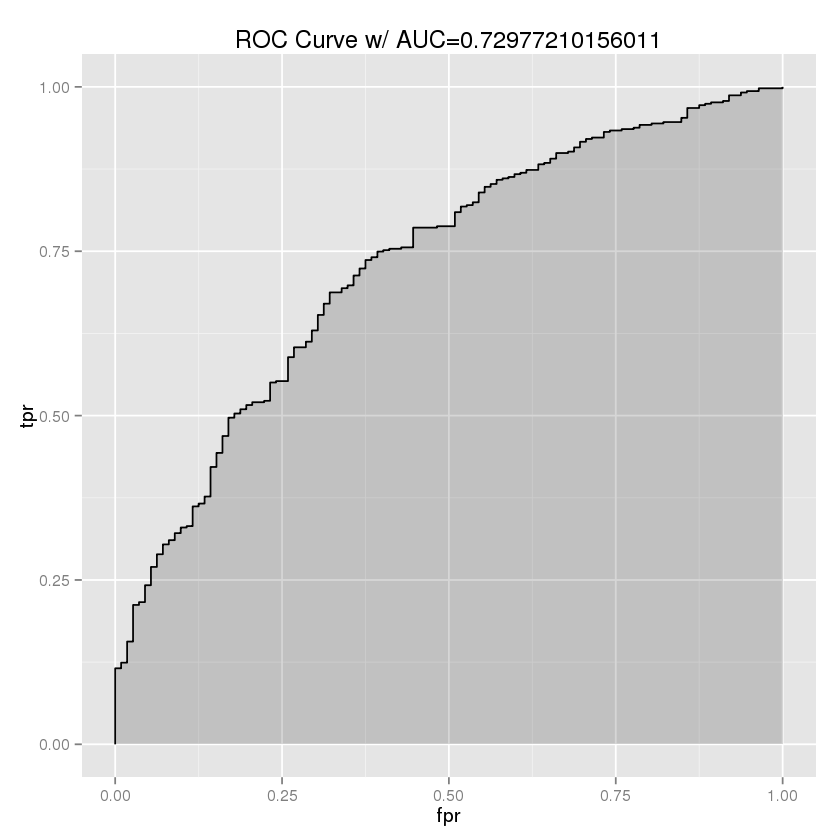

In [54]:
## ROC for Survival Model:

pred_200 <- prediction(data200$Prob, data200$censor)
perf_200 <- performance(pred_200, measure = "tpr", x.measure = "fpr")
auc <- performance(pred_200, measure = "auc")
auc <- auc@y.values[[1]]
roc.data <- data.frame(fpr=unlist(perf_200@x.values),
                       tpr=unlist(perf_200@y.values),
                       model="survival")
ggplot(roc.data, aes(x=fpr, ymin=0, ymax=tpr)) +
    geom_ribbon(alpha=0.2) +
    geom_line(aes(y=tpr)) +
    ggtitle(paste0("ROC Curve w/ AUC=", auc))

In [55]:
### Put all three data sets together. 
output_data <- rbind(data200, data400, data600)

In [56]:
output_data_ordered <- output_data[order(output_data$id),]
row.names(output_data_ordered) <- NULL 
head(output_data_ordered[,c("id", "time", "censor", "Prob", "Sample")], n=9)

,id,time,censor,Prob,Sample
1,1,188,2,0.4900593,200
2,1,188,2,0.7190469,400
3,1,188,2,0.773371,600
4,2,26,2,0.8750759,200
5,2,26,2,0.9801823,400
6,2,26,2,0.9897946,600
7,3,207,2,0.9136229,200
8,3,207,2,0.9901153,400
9,3,207,2,0.9954751,600


##### If we wanted to use classification:

In [57]:
survival_data <- read.csv("uissurv.csv", header=TRUE,
                         colClasses=c(rep('numeric', 6), rep('factor', 3), rep('numeric', 2), 'factor'),
                         )

In [58]:
complete <- complete.cases(survival_data)

In [59]:
survival_data_complete <- survival_data[complete,]

In [60]:
UIS.rf <- randomForest(as.factor(censor) ~ age + beck + hercoc + ivhx + ndrugtx + race + treat + site + los, 
                              data=survival_data_complete, importance=TRUE, ntree=200)

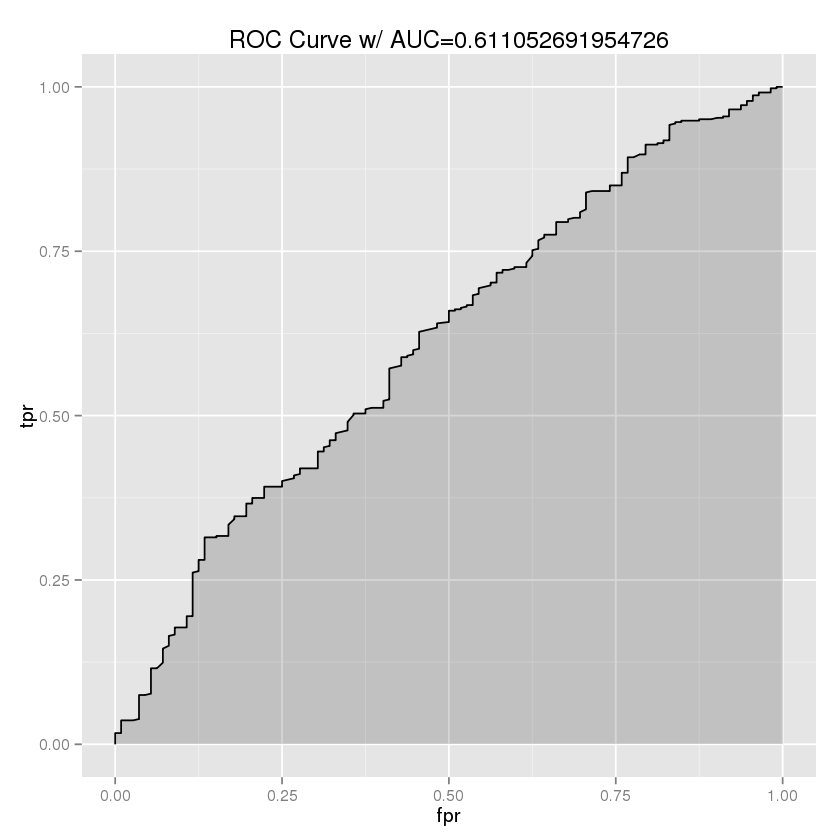

In [61]:
## ROC for RF:

predictions_rf=as.vector(UIS.rf$votes[,2])
pred_rf=prediction(predictions_rf,survival_data_complete$censor)

perf_rf <- performance(pred_rf, measure = "tpr", x.measure = "fpr")
auc <- performance(pred_rf, measure = "auc")
auc <- auc@y.values[[1]]
roc.data <- data.frame(fpr=unlist(perf_rf@x.values),
                       tpr=unlist(perf_rf@y.values),
                       model="rf")
ggplot(roc.data, aes(x=fpr, ymin=0, ymax=tpr)) +
    geom_ribbon(alpha=0.2) +
    geom_line(aes(y=tpr)) +
    ggtitle(paste0("ROC Curve w/ AUC=", auc))

## More Resources

The recommended text book: “Applied Longitudinal Data Analysis: Modeling Change and Event Occurrence" by Judith D. Singer and John B. Willett. Particularly, take a look at Chapter 11. 

For a quick and easy start, I would suggest this ppt from Harvard University: http://www.people.fas.harvard.edu/~plam/teaching/methods/survival/survival_present_print.pdf

For more advanced applications, please look at: https://dash.harvard.edu/bitstream/handle/1/9385643/Zhao_gsas.harvard_0084L_10245.pdf?sequence=1 
and http://aisel.aisnet.org/cgi/viewcontent.cgi?article=3223&context=misq (The latter particularly uses survival analysis in the network security context and I know one of the authors in person. So if you have any questions, I can help you reaching out to him.)

In terms of writing the code I don’t want to try comparing Python and R, but honestly R is more suited for this kind of analysis. You’ll find all the packages you need here: https://cran.r-project.org/web/views/Survival.html

Data for Practice: https://www.umass.edu/statdata/statdata/stat-survival.html